In [15]:
from google.colab import files
print("필요 파일 업로드: sentiment_sign_agreement_merged.xlsx")
uploaded = files.upload()

필요 파일 업로드: sentiment_sign_agreement_merged.xlsx


Saving sentiment_sign_agreement_merged.xlsx to sentiment_sign_agreement_merged (1).xlsx


In [16]:
import pandas as pd

df = pd.read_excel('sentiment_sign_agreement_merged.xlsx')
print(df.columns.tolist())

['transport_trip_id', '정시성', '소요시간', '환승편의', '혼잡도', '쾌적성', '종합 만족도', '요인 개수']


Best hyperparameters: {'C': np.float64(0.3593813663804626), 'penalty': 'l2', 'solver': 'liblinear'}
Best CV accuracy: 0.8683544303797468
Test set accuracy: 0.8455696202531645
Feature importances:
쾌적성     2.171061
환승편의    2.129672
혼잡도     1.849007
정시성     1.823135
소요시간    1.702181
dtype: float64


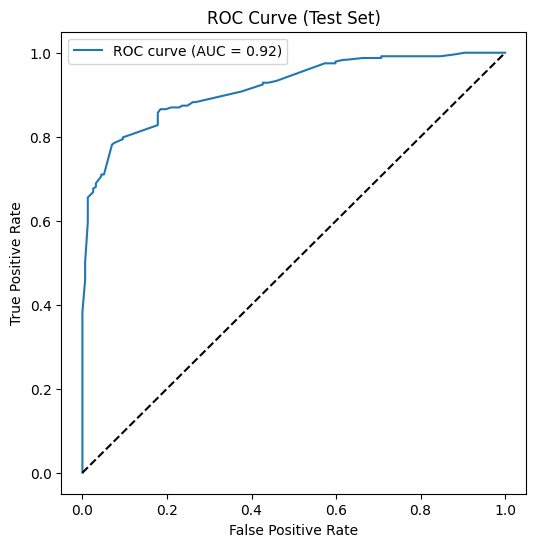

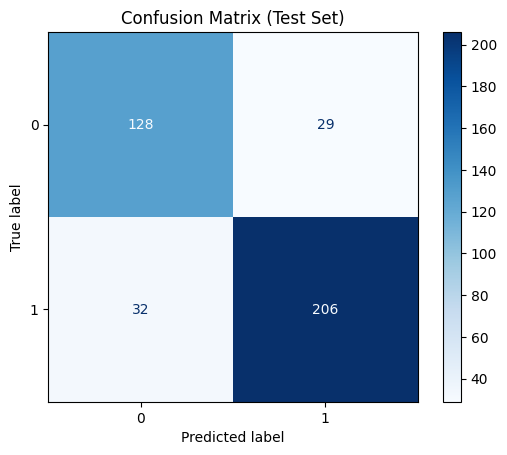

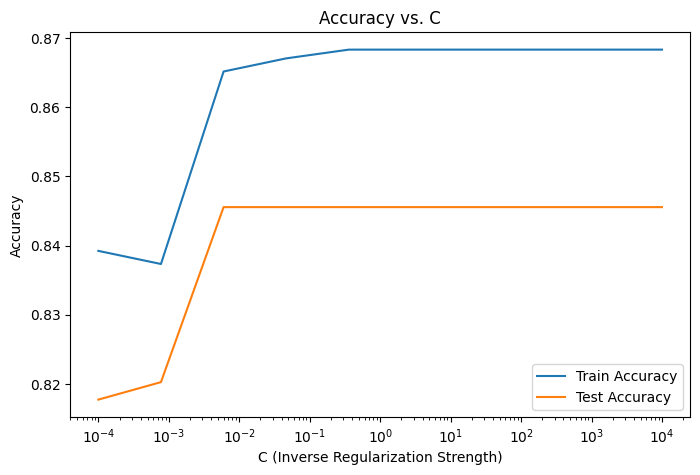

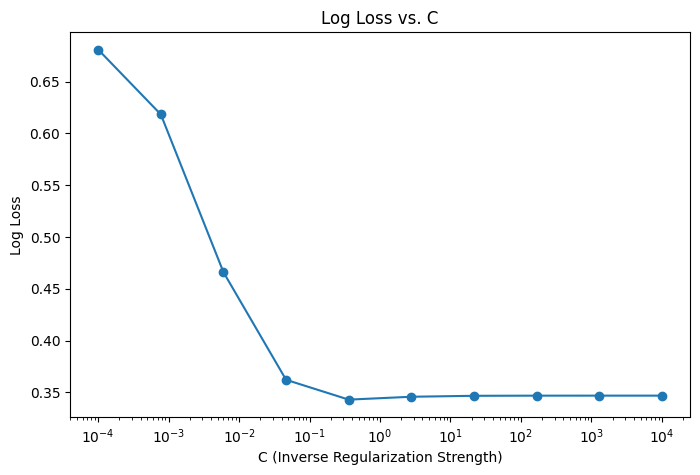

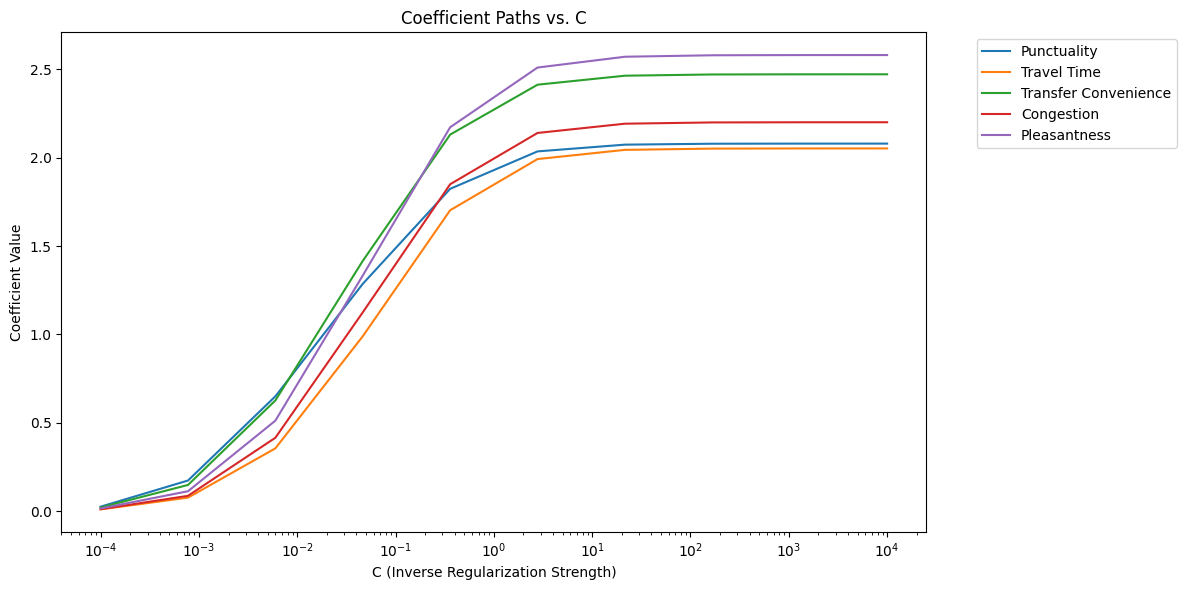

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, roc_curve, roc_auc_score,
    confusion_matrix, ConfusionMatrixDisplay, log_loss
)

# 1. Data loading and preprocessing (use Korean column names)
df = pd.read_excel('sentiment_sign_agreement_merged.xlsx')

# Define Korean column names (verify these match your actual data)
X = df[['정시성', '소요시간', '환승편의', '혼잡도', '쾌적성']]
y = (df['종합 만족도'] >= 0).astype(int)

X = X.fillna(0)

# 2. Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 3. Hyperparameter tuning with cross-validation
param_grid = {
    'C': np.logspace(-4, 4, 10),
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}
grid = GridSearchCV(LogisticRegression(max_iter=1000), param_grid, cv=5, scoring='accuracy')
grid.fit(X_train, y_train)

print("Best hyperparameters:", grid.best_params_)
print("Best CV accuracy:", grid.best_score_)

# 4. Final model training and evaluation
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:,1]

print('Test set accuracy:', accuracy_score(y_test, y_pred))

# 5. Feature importance (using Korean names internally)
importance = pd.Series(best_model.coef_[0], index=X.columns).sort_values(ascending=False)
print('Feature importances:')
print(importance)

# 6. ROC curve (English labels)
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
auc = roc_auc_score(y_test, y_proba)
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc:.2f})')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Test Set)')
plt.legend()
plt.show()

# 7. Confusion matrix (no translation needed)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix (Test Set)')
plt.show()

# 8. Accuracy vs. C (English labels)
C_values = np.logspace(-4, 4, 10)
train_scores, test_scores, log_losses = [], [], []
for C in C_values:
    m = LogisticRegression(C=C, penalty=grid.best_params_['penalty'],
                           solver='liblinear', max_iter=1000)
    m.fit(X_train, y_train)
    train_scores.append(m.score(X_train, y_train))
    test_scores.append(m.score(X_test, y_test))
    y_proba_tmp = m.predict_proba(X_test)[:,1]
    log_losses.append(log_loss(y_test, y_proba_tmp))

plt.figure(figsize=(8,5))
plt.plot(C_values, train_scores, label='Train Accuracy')
plt.plot(C_values, test_scores, label='Test Accuracy')
plt.xscale('log')
plt.xlabel('C (Inverse Regularization Strength)')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. C')
plt.legend()
plt.show()

# 9. Log loss vs. C (English labels)
plt.figure(figsize=(8,5))
plt.plot(C_values, log_losses, marker='o')
plt.xscale('log')
plt.xlabel('C (Inverse Regularization Strength)')
plt.ylabel('Log Loss')
plt.title('Log Loss vs. C')
plt.show()

# 10. Coefficient paths vs. C (translated labels)
column_translation = {
    '정시성': 'Punctuality',
    '소요시간': 'Travel Time',
    '환승': 'Transfer',
    '환승편의': 'Transfer Convenience',
    '역내도보거리': 'Walk Distance Inside Station',
    '역외도보거리': 'Walk Distance Outside Station',
    '이동거리': 'Travel Distance',
    '혼잡도': 'Congestion',
    '비용': 'Cost',
    '쾌적성': 'Pleasantness',
    '날씨': 'Weather',
    '익숙함': 'Familiarity',
    '시간대': 'Time Slot',
    '기타': 'Others'
}

plt.figure(figsize=(12,6))
for i, col in enumerate(X.columns):
    coefs = []
    for C in C_values:
        m = LogisticRegression(C=C, penalty=grid.best_params_['penalty'],
                               solver='liblinear', max_iter=1000)
        m.fit(X_train, y_train)
        coefs.append(m.coef_[0][i])
    plt.plot(C_values, coefs, label=column_translation[col])
plt.xscale('log')
plt.xlabel('C (Inverse Regularization Strength)')
plt.ylabel('Coefficient Value')
plt.title('Coefficient Paths vs. C')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score

# --- Step 1.1: Recreate the model to get the same predictions ---

# Load data and define features/target
# Ensure this file is in the same directory as your script, or provide the full path.
try:
    df = pd.read_excel('sentiment_sign_agreement_merged.xlsx')
except FileNotFoundError:
    print("Error: 'sentiment_sign_agreement_merged.xlsx' not found.")
    print("Please make sure the Excel file is in the same folder as this script.")
    exit()


X = df[['정시성', '소요시간', '환승편의', '혼잡도', '쾌적성']]
y = (df['종합 만족도'] >= 0).astype(int)
X = X.fillna(0) # Using the same preprocessing as before

# Use the same train/test split to ensure we are looking at the identical test set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Train the best logistic regression model from your previous analysis
# Best hyperparameters from GridSearchCV: {'C': 0.3593..., 'penalty': 'l2'}
best_lr_model = LogisticRegression(
    C=0.3593813663804626,
    penalty='l2',
    solver='liblinear',
    max_iter=1000
)
best_lr_model.fit(X_train, y_train)

# Get predictions on the test set
y_pred = best_lr_model.predict(X_test)


# --- Step 1.2: Isolate the False Positives and False Negatives ---

# Add the true labels and predictions to the test set features for easy inspection
X_test_with_info = X_test.copy()
X_test_with_info['True_Label'] = y_test
X_test_with_info['Predicted_Label'] = y_pred

# Filter for False Positives (Predicted 'Satisfied', but was 'Dissatisfied')
fp_filter = (X_test_with_info['Predicted_Label'] == 1) & (X_test_with_info['True_Label'] == 0)
false_positives_df = X_test_with_info[fp_filter]

# Filter for False Negatives (Predicted 'Satisfied', but was 'Satisfied')
fn_filter = (X_test_with_info['Predicted_Label'] == 0) & (X_test_with_info['True_Label'] == 1)
false_negatives_df = X_test_with_info[fn_filter]


# --- Step 1.3: Display the errors and their statistics for analysis ---

print("\n--- ANALYSIS OF MODEL ERRORS ---")
print(f"Found {len(false_positives_df)} False Positives (Predicted 'Satisfied', but actually 'Dissatisfied')")
print("--- Statistics for False Positives ---")
# Using .describe() provides a statistical summary of these specific errors
print(false_positives_df[['정시성', '소요시간', '환승편의', '혼잡도', '쾌적성']].describe())
print("\n" + "="*60 + "\n")

print(f"Found {len(false_negatives_df)} False Negatives (Predicted 'Dissatisfied', but actually 'Satisfied')")
print("--- Statistics for False Negatives ---")
print(false_negatives_df[['정시성', '소요시간', '환승편의', '혼잡도', '쾌적성']].describe())
print("\n" + "="*60 + "\n")

print("--- For Comparison: Statistics for the ENTIRE Test Set ---")
print(X_test.describe())
print("\n" + "="*60 + "\n")


# --- Step 1.4: Calculate and Display Additional Metrics ---
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("--- Additional Evaluation Metrics ---")
print(f"Precision: {precision:.4f} (Of all predicted 'Satisfied', {precision:.1%} were correct)")
print(f"Recall: {recall:.4f} (Of all actual 'Satisfied' users, {recall:.1%} were correctly identified)")
print(f"F1-Score: {f1:.4f} (A balanced measure of Precision and Recall)")



--- ANALYSIS OF MODEL ERRORS ---
Found 29 False Positives (Predicted 'Satisfied', but actually 'Dissatisfied')
--- Statistics for False Positives ---
             정시성       소요시간       환승편의        혼잡도        쾌적성
count  29.000000  29.000000  29.000000  29.000000  29.000000
mean    0.379310   0.103448  -0.482759  -0.034483   0.103448
std     0.775232   0.309934   0.687682   0.325440   0.488791
min    -1.000000   0.000000  -1.000000  -1.000000  -1.000000
25%     0.000000   0.000000  -1.000000   0.000000   0.000000
50%     1.000000   0.000000  -1.000000   0.000000   0.000000
75%     1.000000   0.000000   0.000000   0.000000   0.000000
max     1.000000   1.000000   1.000000   1.000000   1.000000


Found 32 False Negatives (Predicted 'Dissatisfied', but actually 'Satisfied')
--- Statistics for False Negatives ---
             정시성       소요시간       환승편의        혼잡도        쾌적성
count  32.000000  32.000000  32.000000  32.000000  32.000000
mean   -0.468750   0.000000  -0.468750  -0.187500   0.00000

Starting XGBoost hyperparameter tuning with GridSearchCV...
This may take a few minutes...
Fitting 3 folds for each of 18 candidates, totalling 54 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:20:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Best XGBoost hyperparameters found: {'eval_metric': 'logloss', 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'use_label_encoder': False}

--- MODEL PERFORMANCE COMPARISON ---
------------------------------------
Metric		Logistic Regression	XGBoost
-------------------------------------------------------
Accuracy	0.8456			0.8354
AUC Score	0.9173			0.9228
F1-Score	0.8710			0.8632
Precision	0.8766			0.8650
Recall		0.8655			0.8613
-------------------------------------------------------

Displaying comparison plot...


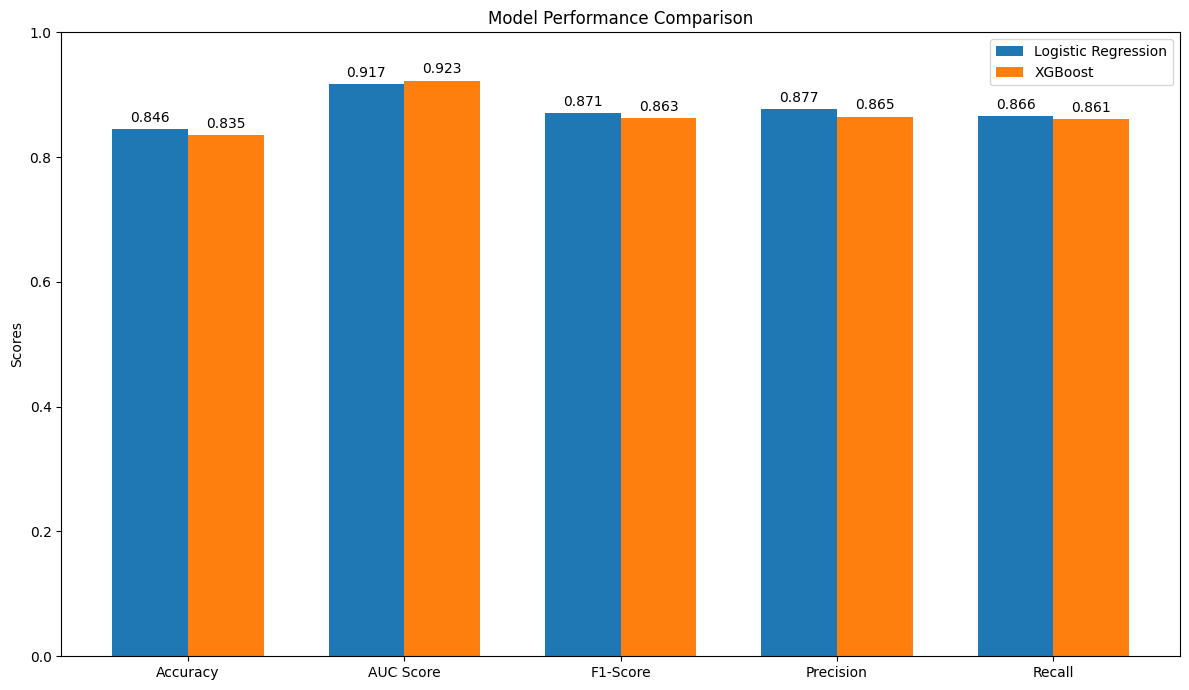

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_score, recall_score

# You may need to install xgboost first:
# pip install xgboost
try:
    from xgboost import XGBClassifier
except ImportError:
    print("XGBoost not found. Please install it using: pip install xgboost")
    exit()


# --- Step 2.1: Load and prepare data (same as before) ---

try:
    df = pd.read_excel('sentiment_sign_agreement_merged.xlsx')
except FileNotFoundError:
    print("Error: 'sentiment_sign_agreement_merged.xlsx' not found.")
    print("Please make sure the Excel file is in the same folder as this script.")
    exit()

X = df[['정시성', '소요시간', '환승편의', '혼잡도', '쾌적성']]
y = (df['종합 만족도'] >= 0).astype(int)
X = X.fillna(0)

# Use the same train/test split for a fair comparison
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# --- Step 2.2: Train and Evaluate the Baseline (Logistic Regression) ---

# Train the best logistic regression model
lr_model = LogisticRegression(
    C=0.3593813663804626, penalty='l2', solver='liblinear', max_iter=1000
)
lr_model.fit(X_train, y_train)
lr_pred = lr_model.predict(X_test)
lr_proba = lr_model.predict_proba(X_test)[:, 1]


# --- Step 2.3: Tune and Train the Challenger (XGBoost) ---

print("Starting XGBoost hyperparameter tuning with GridSearchCV...")
print("This may take a few minutes...")

# Define a parameter grid for XGBoost. This is a starting point.
# A more exhaustive search could include more values.
param_grid_xgb = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.05, 0.1],
    'use_label_encoder': [False],
    'eval_metric': ['logloss']
}

# Set up GridSearchCV
xgb = XGBClassifier(random_state=42)
grid_search_xgb = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid_xgb,
    cv=3,  # 3-fold cross-validation is faster for this demo
    scoring='roc_auc',
    verbose=1,
    n_jobs=-1 # Use all available CPU cores
)

# Fit the grid search to the data
grid_search_xgb.fit(X_train, y_train)

print("\nBest XGBoost hyperparameters found:", grid_search_xgb.best_params_)

# Get the best XGBoost model
best_xgb_model = grid_search_xgb.best_estimator_
xgb_pred = best_xgb_model.predict(X_test)
xgb_proba = best_xgb_model.predict_proba(X_test)[:, 1]


# --- Step 2.4: Compare the Results ---

# Store scores in variables for plotting later
lr_scores = {
    'Accuracy': accuracy_score(y_test, lr_pred),
    'AUC Score': roc_auc_score(y_test, lr_proba),
    'F1-Score': f1_score(y_test, lr_pred),
    'Precision': precision_score(y_test, lr_pred),
    'Recall': recall_score(y_test, lr_pred)
}
xgb_scores = {
    'Accuracy': accuracy_score(y_test, xgb_pred),
    'AUC Score': roc_auc_score(y_test, xgb_proba),
    'F1-Score': f1_score(y_test, xgb_pred),
    'Precision': precision_score(y_test, xgb_pred),
    'Recall': recall_score(y_test, xgb_pred)
}

print("\n--- MODEL PERFORMANCE COMPARISON ---")
print("------------------------------------")
print("Metric\t\tLogistic Regression\tXGBoost")
print("-------------------------------------------------------")
print(f"Accuracy\t{lr_scores['Accuracy']:.4f}\t\t\t{xgb_scores['Accuracy']:.4f}")
print(f"AUC Score\t{lr_scores['AUC Score']:.4f}\t\t\t{xgb_scores['AUC Score']:.4f}")
print(f"F1-Score\t{lr_scores['F1-Score']:.4f}\t\t\t{xgb_scores['F1-Score']:.4f}")
print(f"Precision\t{lr_scores['Precision']:.4f}\t\t\t{xgb_scores['Precision']:.4f}")
print(f"Recall\t\t{lr_scores['Recall']:.4f}\t\t\t{xgb_scores['Recall']:.4f}")
print("-------------------------------------------------------")


# --- Step 2.5: Plot the Comparison ---

labels = list(lr_scores.keys())
lr_values = list(lr_scores.values())
xgb_values = list(xgb_scores.values())

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(12, 7))
rects1 = ax.bar(x - width/2, lr_values, width, label='Logistic Regression')
rects2 = ax.bar(x + width/2, xgb_values, width, label='XGBoost')

# Add some text for labels, title and axes ticks
ax.set_ylabel('Scores')
ax.set_title('Model Performance Comparison')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
ax.set_ylim(0, 1) # Set y-axis limit to be between 0 and 1

# Function to attach a text label above each bar, displaying its height.
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

print("\nDisplaying comparison plot...")
plt.show()


Creating new interaction features...
New features created.

Re-tuning Logistic Regression with new features...
Best LR Hyperparameters: {'C': np.float64(21.54434690031882), 'penalty': 'l2', 'solver': 'liblinear'}

Starting XGBoost hyperparameter tuning with new features...
This may take a few minutes...
Fitting 3 folds for each of 18 candidates, totalling 54 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:26:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Best XGBoost hyperparameters found: {'eval_metric': 'logloss', 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'use_label_encoder': False}

--- MODEL PERFORMANCE COMPARISON (WITH NEW FEATURES) ---
----------------------------------------------------------
Metric		Logistic Regression	XGBoost
----------------------------------------------------------
Accuracy	0.8456			0.8354
AUC Score	0.9180			0.9227
F1-Score	0.8710			0.8632
Precision	0.8766			0.8650
Recall		0.8655			0.8613
----------------------------------------------------------

Displaying comparison plot...


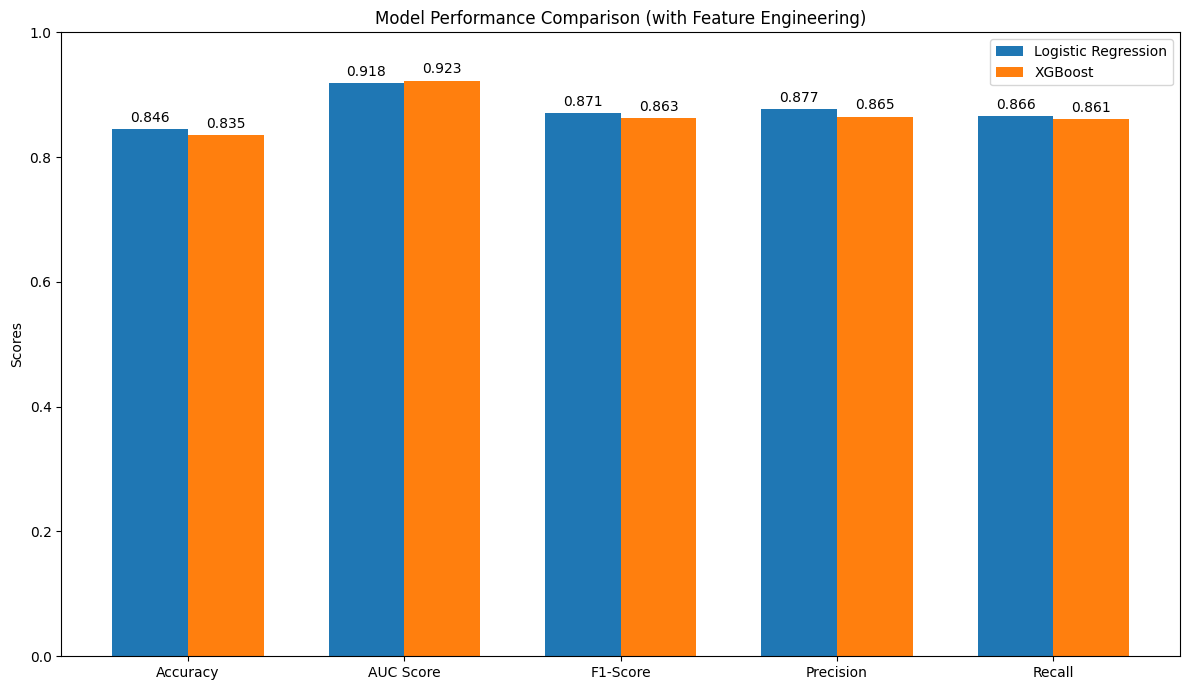

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_score, recall_score

# You may need to install xgboost first:
# pip install xgboost
try:
    from xgboost import XGBClassifier
except ImportError:
    print("XGBoost not found. Please install it using: pip install xgboost")
    exit()


# --- Step 2.1: Load and prepare data (same as before) ---

try:
    df = pd.read_excel('sentiment_sign_agreement_merged.xlsx')
except FileNotFoundError:
    print("Error: 'sentiment_sign_agreement_merged.xlsx' not found.")
    print("Please make sure the Excel file is in the same folder as this script.")
    exit()

X_original = df[['정시성', '소요시간', '환승편의', '혼잡도', '쾌적성']]
y = (df['종합 만족도'] >= 0).astype(int)
X_original = X_original.fillna(0)

# --- NEW: Step 2.2: Feature Engineering ---
print("Creating new interaction features...")
X = X_original.copy()
# This feature helps the model understand the trade-off between pleasantness and congestion.
X['Pleasant_x_Congestion'] = X['쾌적성'] * X['혼잡도']
print("New features created.")


# --- Step 2.3: Train/test split ---
# Use the new feature-engineered X
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# --- Step 2.4: Train and Evaluate the Baseline (Logistic Regression) ---

# We should re-tune the model since we added a new feature
print("\nRe-tuning Logistic Regression with new features...")
param_grid_lr = {
    'C': np.logspace(-4, 4, 10),
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}
grid_lr = GridSearchCV(LogisticRegression(max_iter=1000), param_grid_lr, cv=5, scoring='roc_auc')
grid_lr.fit(X_train, y_train)
lr_model = grid_lr.best_estimator_
print("Best LR Hyperparameters:", grid_lr.best_params_)

lr_pred = lr_model.predict(X_test)
lr_proba = lr_model.predict_proba(X_test)[:, 1]


# --- Step 2.5: Tune and Train the Challenger (XGBoost) ---

print("\nStarting XGBoost hyperparameter tuning with new features...")
print("This may take a few minutes...")

param_grid_xgb = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.05, 0.1],
    'use_label_encoder': [False],
    'eval_metric': ['logloss']
}

xgb = XGBClassifier(random_state=42)
grid_search_xgb = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid_xgb,
    cv=3,
    scoring='roc_auc',
    verbose=1,
    n_jobs=-1
)
grid_search_xgb.fit(X_train, y_train)

print("\nBest XGBoost hyperparameters found:", grid_search_xgb.best_params_)

best_xgb_model = grid_search_xgb.best_estimator_
xgb_pred = best_xgb_model.predict(X_test)
xgb_proba = best_xgb_model.predict_proba(X_test)[:, 1]


# --- Step 2.6: Compare the Results ---

lr_scores = {
    'Accuracy': accuracy_score(y_test, lr_pred),
    'AUC Score': roc_auc_score(y_test, lr_proba),
    'F1-Score': f1_score(y_test, lr_pred),
    'Precision': precision_score(y_test, lr_pred),
    'Recall': recall_score(y_test, lr_pred)
}
xgb_scores = {
    'Accuracy': accuracy_score(y_test, xgb_pred),
    'AUC Score': roc_auc_score(y_test, xgb_proba),
    'F1-Score': f1_score(y_test, xgb_pred),
    'Precision': precision_score(y_test, xgb_pred),
    'Recall': recall_score(y_test, xgb_pred)
}

print("\n--- MODEL PERFORMANCE COMPARISON (WITH NEW FEATURES) ---")
print("----------------------------------------------------------")
print("Metric\t\tLogistic Regression\tXGBoost")
print("----------------------------------------------------------")
print(f"Accuracy\t{lr_scores['Accuracy']:.4f}\t\t\t{xgb_scores['Accuracy']:.4f}")
print(f"AUC Score\t{lr_scores['AUC Score']:.4f}\t\t\t{xgb_scores['AUC Score']:.4f}")
print(f"F1-Score\t{lr_scores['F1-Score']:.4f}\t\t\t{xgb_scores['F1-Score']:.4f}")
print(f"Precision\t{lr_scores['Precision']:.4f}\t\t\t{xgb_scores['Precision']:.4f}")
print(f"Recall\t\t{lr_scores['Recall']:.4f}\t\t\t{xgb_scores['Recall']:.4f}")
print("----------------------------------------------------------")


# --- Step 2.7: Plot the Comparison ---

labels = list(lr_scores.keys())
lr_values = list(lr_scores.values())
xgb_values = list(xgb_scores.values())

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 7))
rects1 = ax.bar(x - width/2, lr_values, width, label='Logistic Regression')
rects2 = ax.bar(x + width/2, xgb_values, width, label='XGBoost')

ax.set_ylabel('Scores')
ax.set_title('Model Performance Comparison (with Feature Engineering)')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
ax.set_ylim(0, 1)

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

print("\nDisplaying comparison plot...")
plt.show()


Creating new interaction features...
New features created.

Re-tuning Logistic Regression with new features...
Best LR Hyperparameters: {'C': np.float64(21.54434690031882), 'penalty': 'l2', 'solver': 'liblinear'}

Starting XGBoost hyperparameter tuning with new features...
This may take a few minutes...
Fitting 3 folds for each of 18 candidates, totalling 54 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:28:33] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Best XGBoost hyperparameters found: {'eval_metric': 'logloss', 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'use_label_encoder': False}

--- MODEL PERFORMANCE COMPARISON (WITH NEW FEATURES) ---
----------------------------------------------------------
Metric		Logistic Regression	XGBoost
----------------------------------------------------------
Accuracy	0.8456			0.8354
AUC Score	0.9180			0.9227
F1-Score	0.8710			0.8632
Precision	0.8766			0.8650
Recall		0.8655			0.8613
----------------------------------------------------------


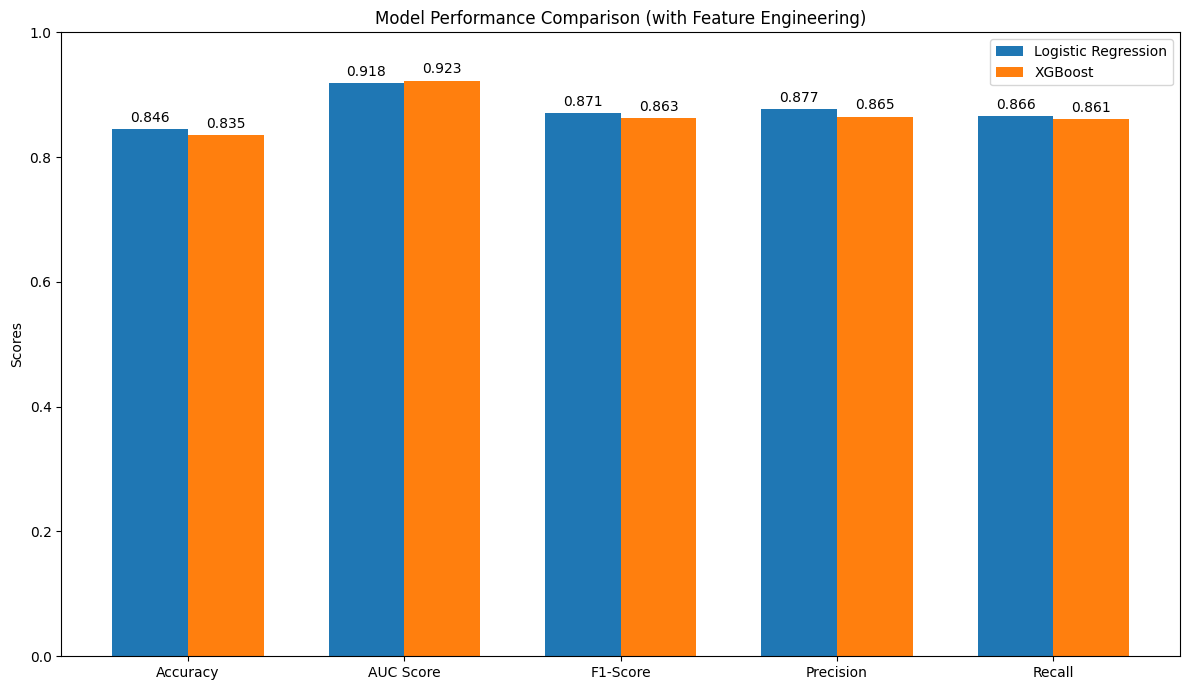


Generating learning curves... this might take a moment.


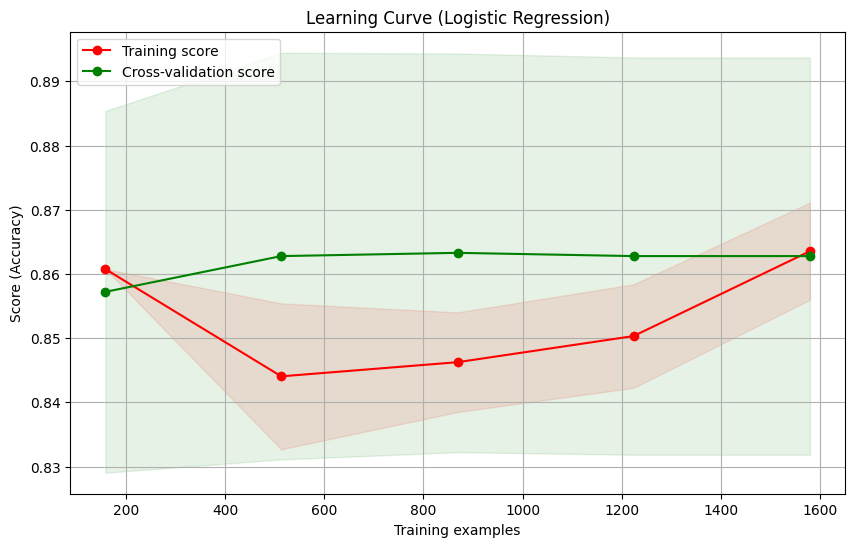

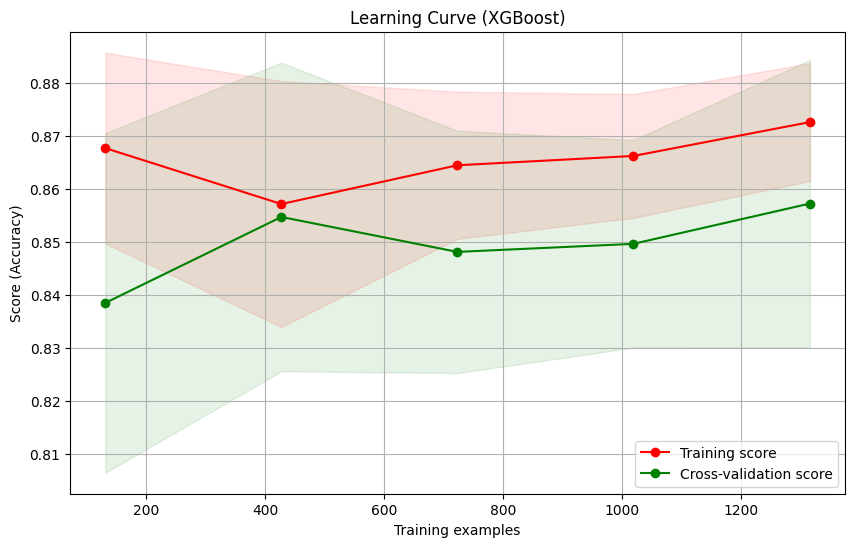

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_score, recall_score

# You may need to install xgboost first:
# pip install xgboost
try:
    from xgboost import XGBClassifier
except ImportError:
    print("XGBoost not found. Please install it using: pip install xgboost")
    exit()


# --- Step 1: Load and prepare data ---

try:
    df = pd.read_excel('sentiment_sign_agreement_merged.xlsx')
except FileNotFoundError:
    print("Error: 'sentiment_sign_agreement_merged.xlsx' not found.")
    print("Please make sure the Excel file is in the same folder as this script.")
    exit()

X_original = df[['정시성', '소요시간', '환승편의', '혼잡도', '쾌적성']]
y = (df['종합 만족도'] >= 0).astype(int)
X_original = X_original.fillna(0)

# --- Step 2: Feature Engineering ---
print("Creating new interaction features...")
X = X_original.copy()
# This feature helps the model understand the trade-off between pleasantness and congestion.
X['Pleasant_x_Congestion'] = X['쾌적성'] * X['혼잡도']
print("New features created.")


# --- Step 3: Train/test split ---
# Use the new feature-engineered X
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# --- Step 4: Train and Evaluate Models ---

# We should re-tune the model since we added a new feature
print("\nRe-tuning Logistic Regression with new features...")
param_grid_lr = {
    'C': np.logspace(-4, 4, 10),
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}
grid_lr = GridSearchCV(LogisticRegression(max_iter=1000), param_grid_lr, cv=5, scoring='roc_auc')
grid_lr.fit(X_train, y_train)
lr_model = grid_lr.best_estimator_
print("Best LR Hyperparameters:", grid_lr.best_params_)

lr_pred = lr_model.predict(X_test)
lr_proba = lr_model.predict_proba(X_test)[:, 1]


print("\nStarting XGBoost hyperparameter tuning with new features...")
print("This may take a few minutes...")

param_grid_xgb = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.05, 0.1],
    'use_label_encoder': [False],
    'eval_metric': ['logloss']
}

xgb = XGBClassifier(random_state=42)
grid_search_xgb = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid_xgb,
    cv=3,
    scoring='roc_auc',
    verbose=1,
    n_jobs=-1
)
grid_search_xgb.fit(X_train, y_train)

print("\nBest XGBoost hyperparameters found:", grid_search_xgb.best_params_)

best_xgb_model = grid_search_xgb.best_estimator_
xgb_pred = best_xgb_model.predict(X_test)
xgb_proba = best_xgb_model.predict_proba(X_test)[:, 1]


# --- Step 5: Compare Final Model Performance ---

lr_scores = {
    'Accuracy': accuracy_score(y_test, lr_pred),
    'AUC Score': roc_auc_score(y_test, lr_proba),
    'F1-Score': f1_score(y_test, lr_pred),
    'Precision': precision_score(y_test, lr_pred),
    'Recall': recall_score(y_test, lr_pred)
}
xgb_scores = {
    'Accuracy': accuracy_score(y_test, xgb_pred),
    'AUC Score': roc_auc_score(y_test, xgb_proba),
    'F1-Score': f1_score(y_test, xgb_pred),
    'Precision': precision_score(y_test, xgb_pred),
    'Recall': recall_score(y_test, xgb_pred)
}

print("\n--- MODEL PERFORMANCE COMPARISON (WITH NEW FEATURES) ---")
# (Table printing code remains the same)
print("----------------------------------------------------------")
print("Metric\t\tLogistic Regression\tXGBoost")
print("----------------------------------------------------------")
print(f"Accuracy\t{lr_scores['Accuracy']:.4f}\t\t\t{xgb_scores['Accuracy']:.4f}")
print(f"AUC Score\t{lr_scores['AUC Score']:.4f}\t\t\t{xgb_scores['AUC Score']:.4f}")
print(f"F1-Score\t{lr_scores['F1-Score']:.4f}\t\t\t{xgb_scores['F1-Score']:.4f}")
print(f"Precision\t{lr_scores['Precision']:.4f}\t\t\t{xgb_scores['Precision']:.4f}")
print(f"Recall\t\t{lr_scores['Recall']:.4f}\t\t\t{xgb_scores['Recall']:.4f}")
print("----------------------------------------------------------")

# Plotting the comparison bar chart
labels = list(lr_scores.keys())
lr_values = list(lr_scores.values())
xgb_values = list(xgb_scores.values())

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 7))
rects1 = ax.bar(x - width/2, lr_values, width, label='Logistic Regression')
rects2 = ax.bar(x + width/2, xgb_values, width, label='XGBoost')

ax.set_ylabel('Scores')
ax.set_title('Model Performance Comparison (with Feature Engineering)')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
ax.set_ylim(0, 1)

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')
autolabel(rects1)
autolabel(rects2)
fig.tight_layout()
plt.show()


# --- NEW: Step 6: Plot Learning Curves ---

def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.
    """
    if axes is None:
        _, axes = plt.subplots(1, 1, figsize=(10, 6))

    axes.set_title(title)
    if ylim is not None:
        axes.set_ylim(*ylim)
    axes.set_xlabel("Training examples")
    axes.set_ylabel("Score (Accuracy)")

    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs,
        train_sizes=train_sizes,
        scoring="accuracy")

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Plot learning curve
    axes.grid()
    axes.fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes.fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes.plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes.plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes.legend(loc="best")

    return plt

print("\nGenerating learning curves... this might take a moment.")

# Plot learning curve for Logistic Regression
plot_learning_curve(lr_model, "Learning Curve (Logistic Regression)", X, y, cv=5, n_jobs=-1)
plt.show()

# Plot learning curve for XGBoost
plot_learning_curve(best_xgb_model, "Learning Curve (XGBoost)", X, y, cv=3, n_jobs=-1)
plt.show()

